# Import Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from collections import Counter
import swifter
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

/home/bini/Documents/repos/Nova-financial-solutions/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/bini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/bini/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Load Data

In [ ]:
# Load the analyst ratings dataset into a DataFrame
df = pd.read_csv("../data/raw_analyst_ratings.csv")
# Quick preview of the data to confirm columns and sample rows
df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


# Preprocessing

In [ ]:
# Compute sentiment polarity for each headline using TextBlob.
# We coerce values to str to avoid errors from NaNs and use swifter to speed up the apply.
df['sentiment'] = df['headline'].swifter.apply(lambda text: TextBlob(str(text)).sentiment.polarity)

Pandas Apply: 100%|██████████| 1407328/1407328 [04:59<00:00, 4692.78it/s] 


# Descriptive Stats

In [ ]:
# Print basic descriptive statistics for numeric columns (e.g., sentiment)
print(df.describe())

         Unnamed: 0     sentiment
count  1.407328e+06  1.407328e+06
mean   7.072454e+05  4.905657e-02
std    4.081009e+05  1.830652e-01
min    0.000000e+00 -1.000000e+00
25%    3.538128e+05  0.000000e+00
50%    7.072395e+05  0.000000e+00
75%    1.060710e+06  0.000000e+00
max    1.413848e+06  1.000000e+00


# Plot headline lengths

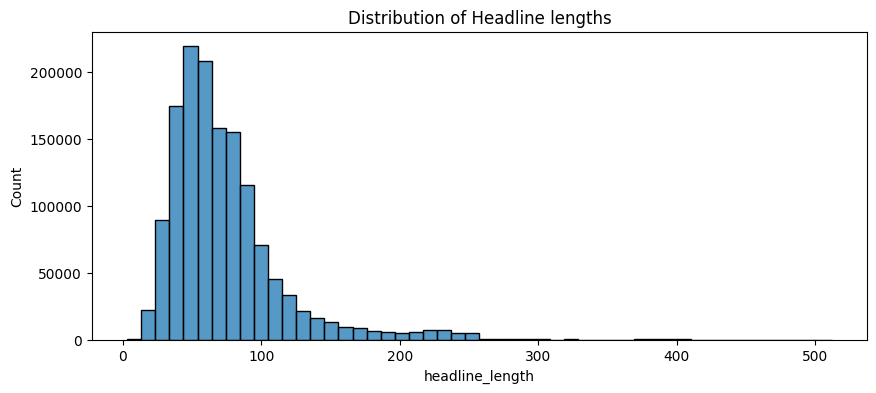

In [ ]:
# Ensure headlines are strings; replace missing values with empty string
df['headline'] = df['headline'].fillna('')  # Replace NaNs with empty strings
# Compute headline length in characters for simple length-based analysis
df['headline_length'] = df['headline'].apply(len),

# Plot the distribution of headline lengths
plt.figure(figsize=(10, 4))
sns.histplot(df['headline_length'], bins=50)
plt.title("Distribution of Headline lengths")
plt.show()

# Sentiment distribution

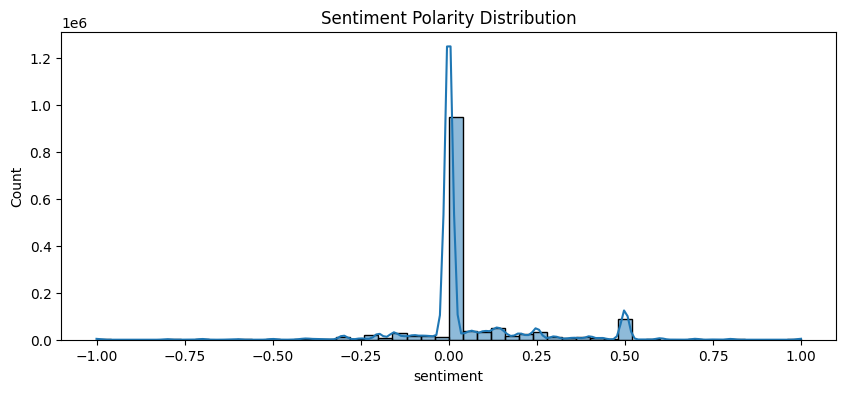

In [ ]:
# Visualize sentiment polarity distribution to understand overall tone
plt.figure(figsize=(10, 4))
sns.histplot(df['sentiment'], bins=50, kde=True)
plt.title("Sentiment Polarity Distribution")
plt.show()

# Articles per publisher

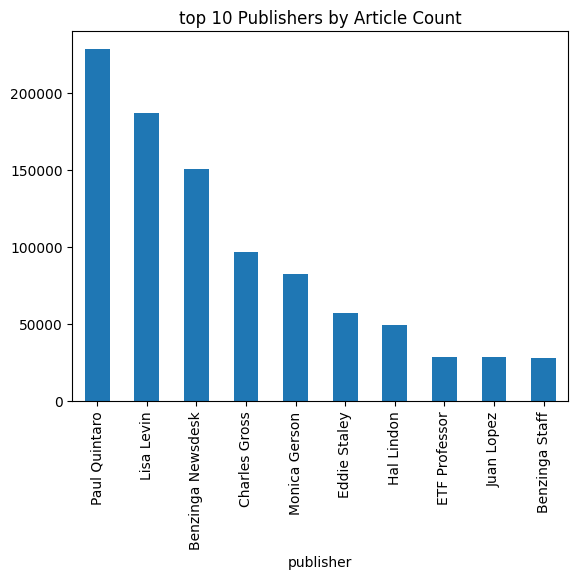

In [ ]:
# Top publishers by article count (plot the 10 largest)
plt.figure(figsize=(12, 5))
df['publisher'].value_counts().nlargest(10).plot(kind='bar')
plt.title("Top 10 Publishers by Article Count")
plt.show()

# Articles over time

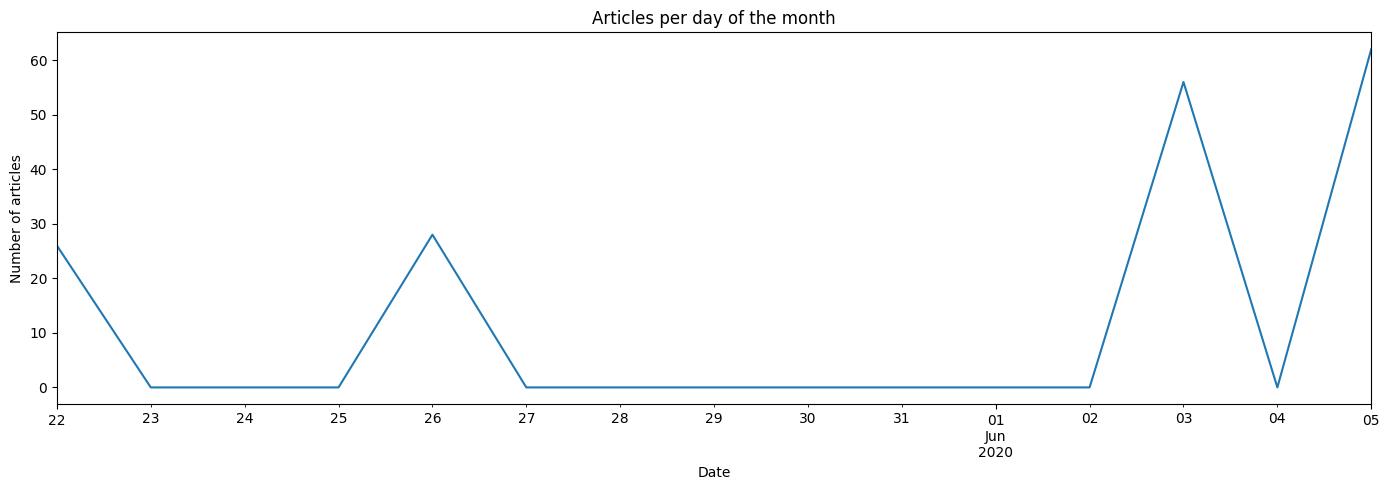

In [ ]:
# Parse dates; coerce invalid values to NaT so they can be dropped
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Remove rows where date parsing failed
df = df.dropna(subset=['date'])

# Count headlines per day by resampling on the date index
df.set_index('date')['headline'].resample('D').count().plot(
    figsize=(14, 5), title="Articles per day"
)

plt.xlabel('Date')
plt.ylabel('Number of articles')
plt.title('Articles per day of the month')
plt.tight_layout()
plt.show()


# Publication Date Trends

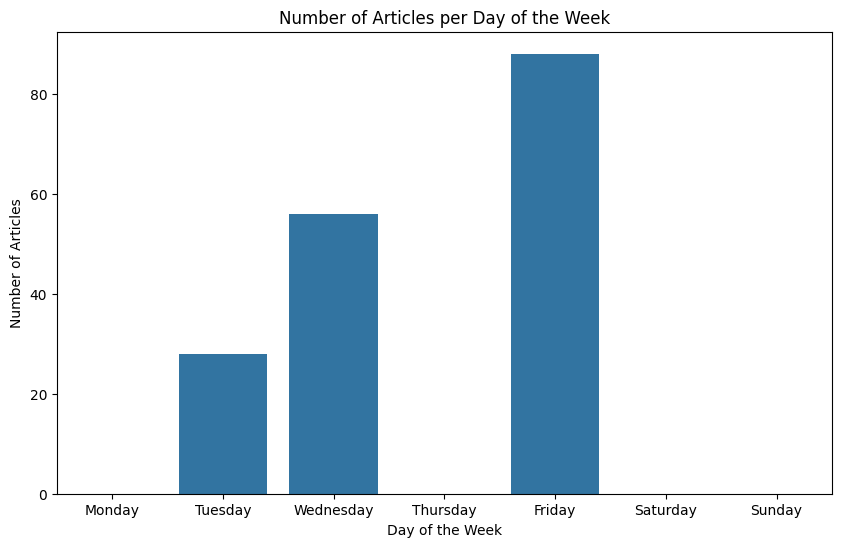

In [ ]:
# Extract day of week from parsed date to find weekday patterns
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.day_name()

plt.figure(figsize=(10,6))
# Order days for readability
sns.countplot(x='day_of_week', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Number of Articles per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Articles')
plt.show()

# Common Keywords

          word  count
0       stocks    137
1          hit    118
2        highs    118
3       friday     92
4    wednesday     56
5      biggest     30
6       movers     28
7       moving     19
8      session     19
9        price      6
10      target      6
11     agilent      5
12   maintains      4
13      raises      3
14     neutral      2
15     changes      2
16           b      1
17  securities      1
18        cfra      1
19        hold      1


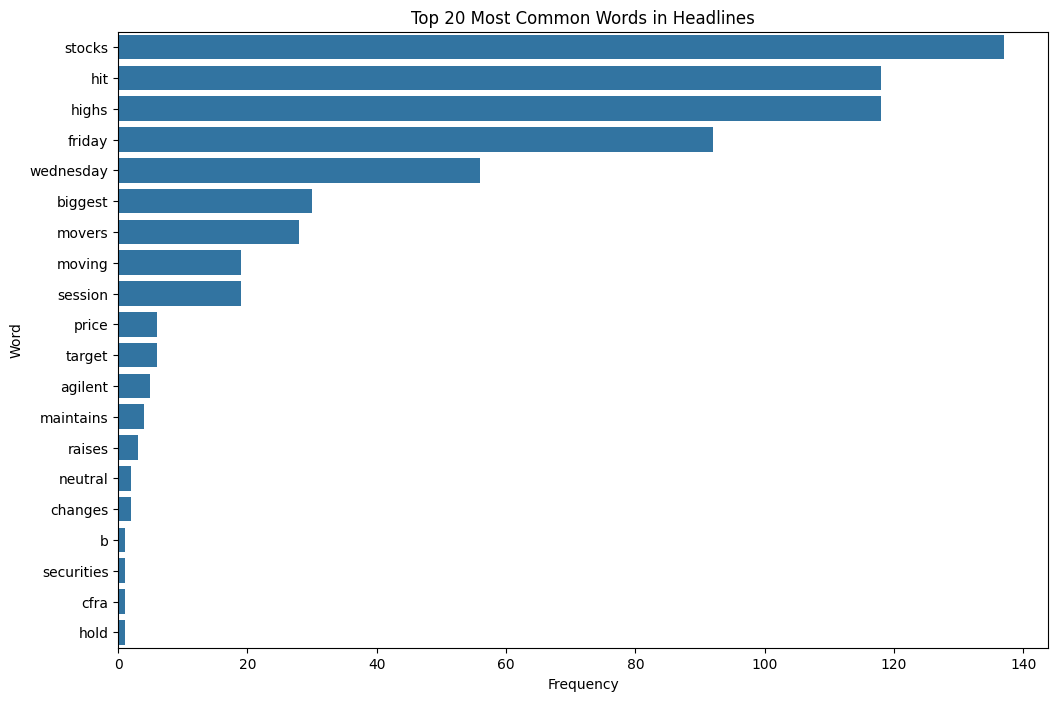

In [ ]:
# Prepare stopwords set for filtering common English words
stop_words = set(stopwords.words('english'))
# Concatenate all headlines into one large string (lowercased for normalization)
all_headlines = ' '.join(df['headline'].str.lower())
# Basic tokenization by splitting on whitespace
words = all_headlines.split()
# Keep only alphabetic tokens and remove stopwords
filtered_words = [word for word in words if word.isalpha() and word not in stop_words]

# Count occurrences and take the top 20 most common words
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(20)

# Convert to DataFrame for easy plotting
common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])
print(common_words_df)

# Plot a horizontal bar chart of the most frequent words
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='word', data=common_words_df)
plt.title('Top 20 Most Common Words in Headlines')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()